In [28]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [29]:
# Load DataFrame
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [30]:
# Inspect head of DataFrame
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
# Inspect DataFrame structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [32]:
# Check number of missing values for each feature
df.isna().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

In [33]:
## Handling missing values

In [34]:
# For features where missing values indicate absence, replace missing values with 'None'.
missing_features = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MasVnrType',
    'MiscFeature',
    'PoolQC'
]

df[missing_features] = df[missing_features].fillna('None')

In [35]:
# Impute missing values for LotFrontage based on median value for each neighborhood
lotfrontage_medians = df.groupby('Neighborhood')['LotFrontage'].median()
lotfrontage_dict = lotfrontage_medians.to_dict()
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [36]:
# Impute missing value for Electrical using most frequent value
most_frequent_electrical = df['Electrical'].mode()[0]
df['Electrical'] = df['Electrical'].fillna(most_frequent_electrical)

In [37]:
df.loc[df['GarageYrBlt'].isna(), 'GarageYrBlt'] = 0
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

In [38]:
## Encoding categorical variables

In [39]:
# Encode ordinal features using the categories provided to define order

ordinal_features = ['BsmtQual', 
                    'BsmtCond', 
                    'BsmtExposure', 
                    'BsmtFinType1', 
                    'BsmtFinType2',
                    'ExterQual', 
                    'ExterCond',
                    'Fence',
                    'FireplaceQu', 
                    'Functional', 
                    'GarageQual',
                    'GarageCond', 
                    'GarageFinish', 
                    'HeatingQC', 
                    'KitchenQual', 
                    'LandSlope',
                    'LandContour',
                    'LotShape', 
                    'PavedDrive', 
                    'PoolQC', 
                    'Utilities'
                   ]

categories_order = [
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  
    ['None', 'No', 'Mn', 'Av', 'Gd'],       
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],        
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['None', 'Unf', 'RFn', 'Fin'],          
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],         
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],         
    ['Sev', 'Mod', 'Gtl'],
    ['Low', 'HLS', 'Bnk', 'Lvl'],
    ['IR3', 'IR2', 'IR1', 'Reg'],           
    ['N', 'P', 'Y'],                       
    ['None', 'Fa', 'TA', 'Gd', 'Ex'],       
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']   
]

encoder = OrdinalEncoder(categories=categories_order)
df[ordinal_features] = encoder.fit_transform(df[ordinal_features])

In [40]:
# Encode nominal features using one-hot encoding

nominal_features = ['Alley',
                    'BldgType',
                    'CentralAir',
                    'Condition1',
                    'Condition2',
                    'Electrical',
                    'Exterior1st',
                    'Exterior2nd',
                    'Foundation',
                    'GarageType',
                    'Heating',
                    'HouseStyle',
                    'LotConfig',
                    'MasVnrType',
                    'MiscFeature',
                    'MSZoning',
                    'Neighborhood',
                    'RoofMatl',
                    'RoofStyle',
                    'SaleCondition',
                    'SaleType',
                    'Street'
                   ]


df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

In [41]:
## Feature engineering

In [42]:
# Create new features 
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']

# Drop original features
features_to_drop = [
    'YearBuilt', 
    'YearRemodAdd',
    'TotalBsmtSF', 
    '1stFlrSF', 
    '2ndFlrSF',
    'GrLivArea',
    'OpenPorchSF', 
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch',
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'FullBath', 
    'HalfBath'
]

df = df.drop(features_to_drop, axis=1)

In [43]:
## Handling outliers

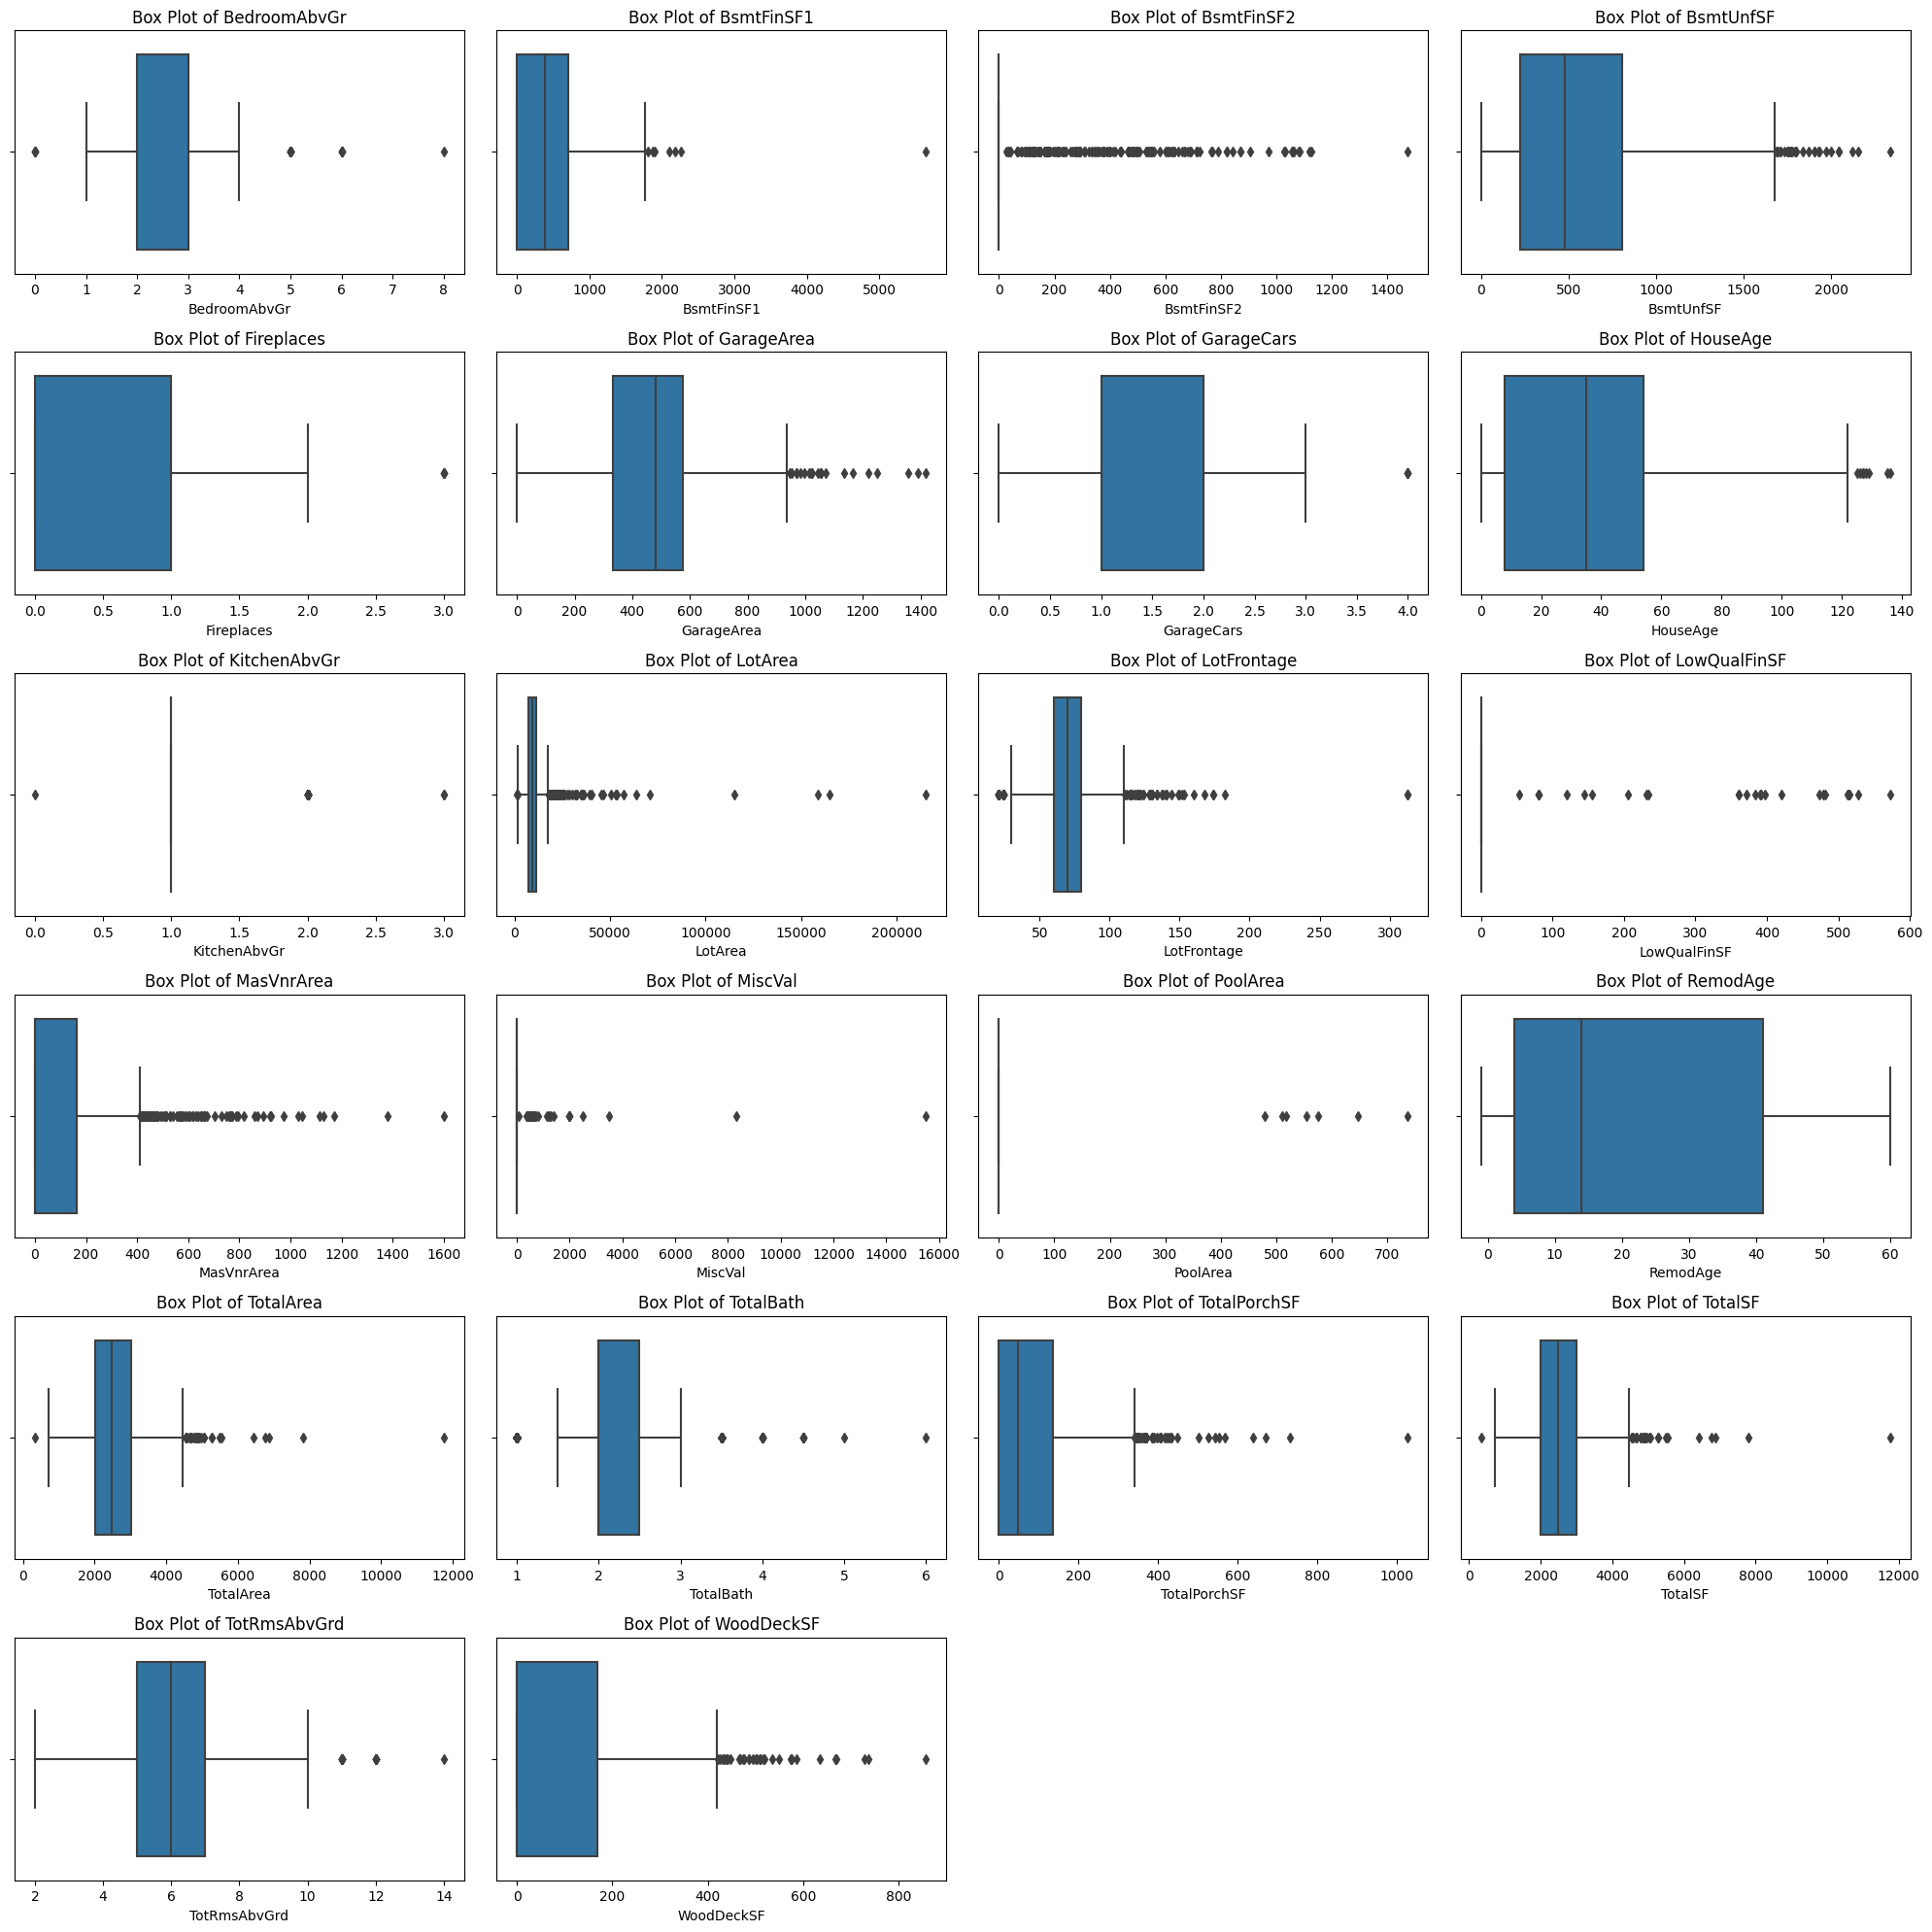

In [44]:
# Check distribution of numerical features

features_to_check = [
    'BedroomAbvGr',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'Fireplaces',
    'GarageArea',
    'GarageCars',
    'HouseAge',
    'KitchenAbvGr',
    'LotArea',
    'LotFrontage',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscVal',
    'PoolArea',
    'RemodAge',
    'TotalArea',
    'TotalBath',
    'TotalPorchSF',
    'TotalSF',
    'TotRmsAbvGrd',
    'WoodDeckSF'
]

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for idx, feature in enumerate(features_to_check):
    sns.boxplot(x=df[feature], ax=axes[idx])
    axes[idx].set_title(f'Box Plot of {feature}')

for idx in range(len(features_to_check), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [45]:
# Drop features with low predictive power due to similar values or high proportion of zero values
df = df.drop(['BsmtFinSF2','KitchenAbvGr', 'LowQualFinSF','MasVnrArea', 'MiscVal', 'PoolArea', ], axis=1)

In [46]:
# Cap features with outliers at the 99th percentile
contains_outliers = ['LotArea', 'LotFrontage', 'TotalArea', 'TotalPorchSF', 'TotalSF', 'WoodDeckSF']

caps = {} 

for outlier in contains_outliers:
    cap = df[outlier].quantile(0.99)
    caps[outlier] = cap
    df[outlier] = np.where(df[outlier] > cap, cap, df[outlier])

In [47]:
# Define features and target variables and split the dataframe into train and test sets
X = df.drop(['Id','SalePrice'], axis=1)
y = df['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Instantiate XGBoost model and perform cross-validation 
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Calculate mean RMSE for the baseline model
xgb_rmse = -xgb_scores.mean()
print(f'Baseline XGBoost RMSE: {xgb_rmse}')

Baseline XGBoost RMSE: 30818.252943154763


In [49]:
# Refine hyperparameters for the model 

xgb_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=kf,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

xgb_random_search.fit(X_train, y_train)

print("Best parameters: ", xgb_random_search.best_params_)

Best parameters:  {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 900, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [50]:
# Run the model again using the best estimator 
best_xgb = xgb_random_search.best_estimator_
y_pred = best_xgb.predict(X_valid)
xgb_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Tuned XGBoost RMSE: {xgb_rmse}')

Tuned XGBoost RMSE: 26091.008520470452


In [51]:
# Load test data for prediction
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [52]:
# Repeat preprocessing steps on unseen data


df_test[missing_features] = df_test[missing_features].fillna('None')

df_test['LotFrontage'] = df_test['LotFrontage'].fillna(df_test['Neighborhood'].map(lotfrontage_dict))

df_test['Electrical'] = df_test['Electrical'].fillna(most_frequent_electrical)

df_test.loc[df_test['GarageYrBlt'].isna(), 'GarageYrBlt'] = 0
df_test.loc[df_test['MasVnrArea'].isna(), 'MasVnrArea'] = 0

df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')

df_test[ordinal_features] = encoder.transform(df_test[ordinal_features])

df_test = pd.get_dummies(df_test, columns=nominal_features, drop_first=True)

df_test['HouseAge'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['RemodAge'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['TotalArea'] = df_test['GrLivArea'] + df_test['TotalBsmtSF']
df_test['TotalPorchSF'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch'] + df_test['ScreenPorch']
df_test['TotalBath'] = df_test['BsmtFullBath'] + 0.5 * df_test['BsmtHalfBath'] + df_test['FullBath'] + 0.5 * df_test['HalfBath']

df_test = df_test.drop(features_to_drop, axis=1, errors='ignore')
df_test = df_test.drop(['BsmtFinSF2','KitchenAbvGr','LowQualFinSF','MasVnrArea','MiscVal','PoolArea'], axis=1, errors='ignore')

for outlier in contains_outliers:
    cap = caps[outlier]  
    df_test[outlier] = np.where(df_test[outlier] > cap, cap, df_test[outlier])

df_test = df_test.drop('Id', axis=1)

final_train_columns = X.columns

# Add any missing columns, drop any extra columns, and reorder columns to ensure the format of the test DataFrame is identical
for col in final_train_columns:
    if col not in df_test.columns and col != 'SalePrice':
        df_test[col] = 0

extra_cols = set(df_test.columns) - set(final_train_columns)
df_test.drop(extra_cols, axis=1, inplace=True)

df_test = df_test[final_train_columns]

In [53]:
# Make predictions on the test set and create the submission DataFrame
y_test_pred = best_xgb.predict(df_test)

test_with_id = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

submission = pd.DataFrame({
    'Id': test_with_id['Id'], 
    'SalePrice': y_test_pred
})

# Save to CSV file
submission.to_csv('submission.csv', index=False)